# Petermann Flowline Model

Use icepack diagnostic/prognostic solver and hybrid model features to make a steady-state, Petermann flowline model
- Takes friction coefficient value from PetermannFlowline_Friction 
- Takes temperature field from PetermannFlowline_HeatTransport

## Setup

### Imports and data

In [1]:
import sys 
import glob
import os

import matplotlib.pyplot as plt
import numpy as np

import rioxarray as rxr
import xarray as xr
import rasterio

import geojson

import firedrake
import icepack
import icepack.plot

fatal: detected dubious ownership in repository at '/mnt/data01/Code/OtherRepos/firedrake/src/PyOP2'
To add an exception for this directory, call:

	git config --global --add safe.directory /mnt/data01/Code/OtherRepos/firedrake/src/PyOP2
firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


### Mesh

In [2]:
flowline_fn = 'Petermann-centerline.nc'
flowline = xr.open_dataset(flowline_fn)

In [3]:
# Establish mesh, function spaces, and vector spaces that variables will live on in the mesh
ld=flowline['linedist'][0]
Lx = np.int(np.round(ld[-1]))
nx = np.int(np.round(ld[-1]/1000))

mesh1d = firedrake.IntervalMesh(nx, Lx)
mesh = firedrake.ExtrudedMesh(mesh1d, layers=1)

Q = firedrake.FunctionSpace(
    mesh, family='CG', degree=2,
    vfamily='R', vdegree=0
)

V = firedrake.FunctionSpace(
    mesh, family='CG', degree=2,
    vfamily='GL', vdegree=2
)

# Define spatial coordinates on the mesh
x, ζ = firedrake.SpatialCoordinate(mesh)

/tmp/ipykernel_230184/3767922216.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  Lx = np.int(np.round(ld[-1]))
/tmp/ipykernel_230184/3767922216.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; fo

### Load/Interpolate Raster Data

In [4]:
### Reading data
root_ddir = '/mnt/data01/Data/'

velocity_fn = glob.glob(root_ddir+'Greenland_Velocity/*.nc')
ice_info_fn = glob.glob(root_ddir+'Greenland_BedElevation/*.nc')[0]
hillshade_fn = glob.glob(root_ddir+'Greenland_Imagery/*.nc') 
hs = xr.open_dataset(hillshade_fn[0])

vx = rxr.open_rasterio(velocity_fn[0])[0,:,:]
vy = rxr.open_rasterio(velocity_fn[1])[0,:,:]
speed = np.sqrt(vx**2+vy**2)

ice_bed_props = rxr.open_rasterio(ice_info_fn)
thickness = ice_bed_props['thickness'][0,:,:]
surface = ice_bed_props['surface'][0,:,:]
bed = ice_bed_props['bed'][0,:,:]

### Get Petermann basin outline
outline_fn='petermann_streamlines_evenspace_full.geojson'
with open(outline_fn, 'r') as outline_file:
    basin_outline = geojson.load(outline_file)

basin_coords = []
for i in basin_outline['features'][0]['geometry']['coordinates']:
    for coord in i:
        basin_coords.append(coord)
basin_coords=np.array(basin_coords)

In [5]:
####### Here we interpolate onto the mesh
h0 = icepack.interpolate_xr(flowline['Thickness'], Q)
s0 = icepack.interpolate_xr(flowline['Surface'], Q)
b = icepack.interpolate_xr(flowline['Bed'], Q)
u0 = icepack.interpolate_xr(flowline['Speed'], V)
smb = icepack.interpolate_xr(flowline['SMB'], Q)

h_in = h0.at([0,0])
s_in = s0.at([0,0])
u_in = u0.at([0,0])
s_out = s0.at([Lx,0])

### Plotting Functions

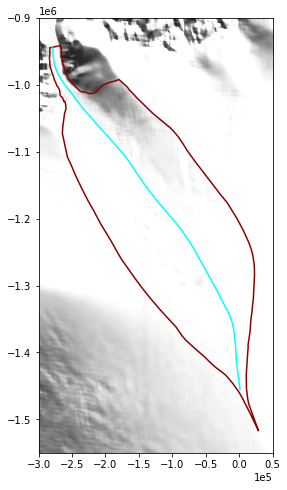

In [6]:
def basin_subplot(*args, **kwargs):
    zoom = kwargs.get("zoom",0)
    image = kwargs.get("image",0)
    fig, ax = plt.subplots(figsize=[8,8])
    im1=ax.imshow(hs['hillshade'].values,
                  extent=[hs['x'].values.min(),hs['x'].values.max(),hs['y'].values.min(),hs['y'].values.max()],
                  cmap='Greys_r', vmin=0,vmax=200,origin='upper')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    
    plt.plot(basin_coords.T[0],basin_coords.T[1],c='darkred')
    
    if zoom == -1:
        ax.set_ylim([-1.6e6,-1e6]);
        ax.set_xlim([-0.325e6,0.1e6]);
    elif zoom == 0:
        ax.set_ylim([-1.55e6,-.9e6]);
        ax.set_xlim([-0.3e6,0.05e6]);
    elif zoom == 1:
        ax.set_ylim(-1.1e6,-0.9e6);
        ax.set_xlim(-3e5,-1.5e5);

    ax.set_aspect('equal')
    
    return fig, ax

fig,ax = basin_subplot()
ax.plot(flowline['x_pol'][0],flowline['y_pol'][0],c='cyan');

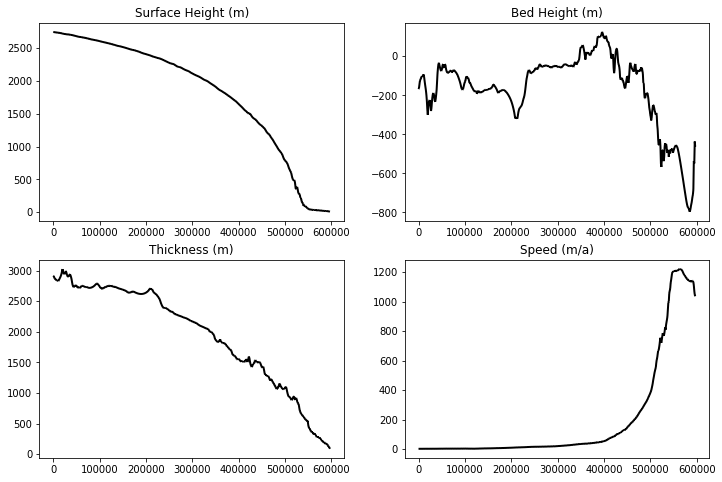

In [7]:
def depth_avg_plot(s0,h0,b,u0,**kwargs):
    figsize = kwargs.get("figsize",(12,8))
    
    fig, ax = plt.subplots(2,2,figsize=figsize)
    
    firedrake.plot(icepack.depth_average(s0),axes=ax[0,0])
    firedrake.plot(icepack.depth_average(h0),axes=ax[1,0])
    firedrake.plot(icepack.depth_average(b),axes=ax[0,1])
    firedrake.plot(icepack.depth_average(u0),axes=ax[1,1])
    ax[0,0].set_title('Surface Height (m)')
    ax[0,1].set_title('Bed Height (m)')
    ax[1,0].set_title('Thickness (m)')
    ax[1,1].set_title('Speed (m/a)')
    return fig, ax

depth_avg_plot(s0,h0,b,u0);

In [9]:
def glacier_z_coords(var, h, s, b, field, xsampling=200, zsampling=100):
    ################# Here, we produce the x and ζ coordinates to extract
    x_opts = np.linspace(0.001,Lx-0.001,xsampling)
    ζ_opts = np.linspace(0.001,0.999,zsampling)
    x_coords_grid,ζ_coords_grid=np.meshgrid(x_opts,ζ_opts)

    orig_size = x_coords_grid.shape
    x_coords_vec = np.reshape(x_coords_grid,[1,np.prod(orig_size)])
    ζ_coords_vec = np.reshape(ζ_coords_grid,[1,np.prod(orig_size)])

    ################# Combine the x and ζ 1D arrays to get an n x 2 array containing all the points we want to extract
    coord_list = np.concatenate([x_coords_vec,ζ_coords_vec]).T

    ################# Here we loop through the list of coordinates and extract the points at relevant values 
    ################# (Firedrake can probably do this without a loop, but I started testing things this way)
    var_extract = []

    for i in coord_list:
        var_extract.append(var.at(i[0],i[1]))

    ################# We turn that into a numpy array, and then we turn it into the shape of the original meshgrids
    var_extract_vec = np.array(var_extract)
    var_extract_grid = np.reshape(var_extract,orig_size)

    ################# Here we create an array of the ice surface elevation values
    surf = np.array(icepack.depth_average(s).at(x_opts))
    ################# Here we create an array of the ice surface elevation values
    bed = np.array(icepack.depth_average(b).at(x_opts))
    ################# And then the ice bed elevation values -- What does the Q do here? I just copied Wills code that worked.
    ice_base = firedrake.interpolate(s - h, field)
    ice_base = np.array(icepack.depth_average(ice_base).at(x_opts))

    ################# Then, using a bit of matrix algebra, we create a (1) matrix of relative thickness positions corresponding to the 
    ################# ζ values, and then we add it to a matrix of the bed elevation values (made to be the same size as the original z mesh grid)
    ################# This produces a matrix, the same size at the x_coords_grid, with corresponding true z for the glacier
    z_coords_grid = np.matmul(np.matrix(ζ_opts).T,np.matrix(surf-ice_base))+np.tile(ice_base,(zsampling,1))
    
    return(var_extract_grid, surf, bed, ice_base, x_opts, x_coords_grid, z_coords_grid)

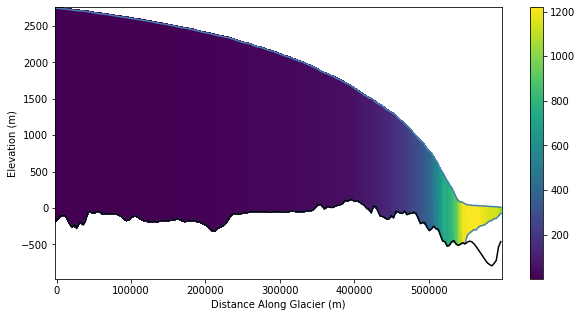

In [13]:
def glacier_plot(var, h, s, b, field, **kwargs):
    xsampling = kwargs.get("xsampling",200)
    zsampling = kwargs.get("ysampling",100)
    fsize = kwargs.get("figsize",(10,5))
    cmap = kwargs.get("cmap")
    vmin = kwargs.get("vmin")
    vmax = kwargs.get("vmax")
    
    (var_extract_grid, surf, bed, ice_b, x_opts, x_coords_grid, z_coords_grid) = glacier_z_coords(var, h, s, b, field, xsampling, zsampling)
    
    fig, ax = plt.subplots(figsize=fsize)

    cdata = plt.pcolor(x_coords_grid,z_coords_grid,var_extract_grid,
                       cmap=cmap,vmin=vmin,vmax=vmax)
    cbar = plt.colorbar(cdata)
    plt.plot(x_opts,surf,c='steelblue')
    plt.plot(x_opts,ice_b,c='steelblue')
    plt.plot(x_opts,bed,c='black')

    plt.xlabel('Distance Along Glacier (m)')
    plt.ylabel('Elevation (m)')
    return fig, ax
initial_glacier=glacier_plot(u0,h0,s0,b,V)

## Modeling

First define friction, temperature/fluidity field, and accumulation rate, and then do diagnostic/prognostic solve

### Friction

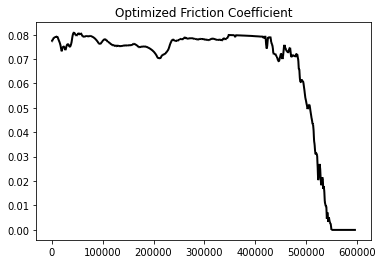

In [14]:
### Import friction parameterization (derived in Petermann-friction-xzflowline)
C=firedrake.Function(Q)

filename = 'Petermann_xzflowline_friction'
with firedrake.DumbCheckpoint(filename, "r") as chk:
    chk.load(C, name="friction")
    
firedrake.plot(icepack.depth_average(C));
plt.title("Optimized Friction Coefficient");

In [15]:
import icepack.models.hybrid
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    year as year,
    gravity as g
)

def friction(**kwargs):
    u = kwargs['velocity']
    h = kwargs['thickness']
    s = kwargs['surface']
    C = kwargs['friction']
    
    p_W = ρ_W * g * firedrake.max_value(0, h - s)
    p_I = ρ_I * g * h
    ϕ = 1 - p_W / p_I
    
    C = C * ϕ
    return icepack.models.friction.bed_friction(velocity=u, friction=C)

### Temperature/Fluidity

In [16]:
T = firedrake.Constant(255.0)
A = icepack.rate_factor(T)

### Accumulation Rate

In [17]:
a = firedrake.Constant(0)

### Model/Solver

In [18]:
model = icepack.models.HybridModel(friction=friction)
opts = {
    "dirichlet_ids": [1],
    "diagnostic_solver_type": "petsc",
    "diagnostic_solver_parameters": {"snes_type": "newtontr"},
}
solver = icepack.solvers.FlowSolver(model, **opts)

In [19]:
h = h0.copy(deepcopy=True)
u = solver.diagnostic_solve(
    velocity=u0,
    thickness=h0,
    surface=s0,
    fluidity=A,
    friction=C
)

100%|██████████| 400/400 [00:15<00:00, 25.50it/s]


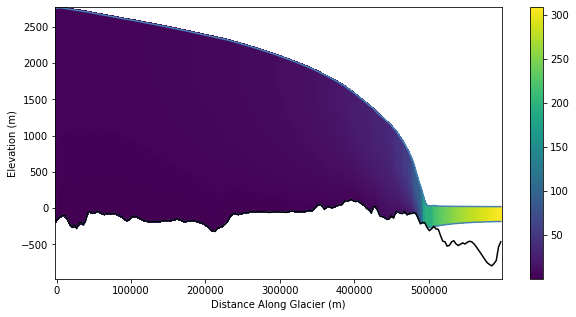

In [20]:
import tqdm

num_years = 400
timesteps_per_year = 1

δt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year

us=[]
hs=[]
ss=[]

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        δt,
        thickness=h,
        velocity=u,
        accumulation=a,
        thickness_inflow=h0
    )
    s = icepack.compute_surface(thickness=h, bed=b)
    
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        surface=s,
        fluidity=A,
        friction=C
    )
    us.append(u)
    hs.append(h)
    ss.append(s)

fig,ax = glacier_plot(u,h,s,b,V)

## Analysis

In [ ]:
import NDH_Tools as ndh

After Generating the Writer, include the following:
Outside the loop:      with writer.saving(fig, videoname, 100):
To capture a frame:    writer.grab_frame()


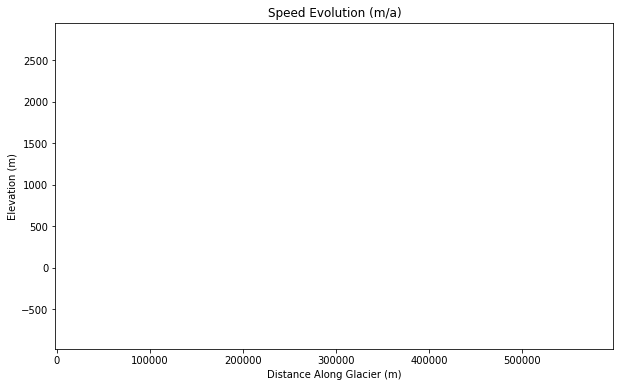

In [23]:
writer = ndh.generate_animation(5,'Slices')
videoname1 = 'Evolution_speed.mp4'

fig, axes = plt.subplots(figsize=(10,6))
axes.set_xlabel('Distance Along Glacier (m)')
axes.set_ylabel('Elevation (m)')
axes.set_title('Speed Evolution (m/a)')
with writer.saving(fig, videoname1, 100):
    for i,u in enumerate(us[::5]):
        (u_extract_grid, surf, bed, ice_b, x_opts, x_coords_grid, z_coords_grid) = glacier_z_coords(u, hs[i], ss[i], b, V,xsampling=200,zsampling=100)

        cdata = axes.pcolor(x_coords_grid,z_coords_grid,u_extract_grid,vmin=0,vmax=1000)
        cbar = plt.colorbar(cdata,label='Speed (m/a)')

        l1=axes.plot(x_opts,surf,c='steelblue')
        l2=axes.plot(x_opts,ice_b,c='steelblue')
        l3=axes.plot(x_opts,bed,c='black')

        writer.grab_frame()
        
        cbar.remove()
        l1.pop(0).remove()
        l2.pop(0).remove()
        l3.pop(0).remove()
        cdata.remove();

In [24]:
ndh.show_video('Evolution_speed.mp4')